In [14]:
import pandas as pd
import os
import glob

def extract_metrics_from_csv_files():
    """
    Extract accuracy and F1 scores from classification report CSV files
    and save them into a summary CSV file with model names.
    """
    
    # Define the base directory containing the evaluation results
    base_dir = "/home/quydx/tinyML/evaluation_results"
    
    # Find all classification_report.csv files
    csv_files = []
    
    # Pattern 1: Files in subdirectories like threshold_X_classes_Y
    pattern1 = os.path.join(base_dir, "*/classification_report.csv")
    csv_files.extend(glob.glob(pattern1))
    
    # Pattern 2: Direct files like eval_binary/classification_report.csv
    pattern2 = os.path.join(base_dir, "../eval_binary/classification_report.csv")
    csv_files.extend(glob.glob(pattern2))
    
    # Also check current directory structure based on your attachments
    additional_patterns = [
        "/home/quydx/tinyML/evaluation_results/threshold_*/classification_report.csv",
        "/home/quydx/tinyML/eval_binary/classification_report.csv"
    ]
    
    for pattern in additional_patterns:
        csv_files.extend(glob.glob(pattern))
    
    # Remove duplicates
    csv_files = list(set(csv_files))
    
    print(f"Found {len(csv_files)} classification report files:")
    for file in csv_files:
        print(f"  - {file}")
    
    # Extract metrics from each file
    results = []
    
    for csv_file in csv_files:
        try:
            # Read the classification report CSV
            df = pd.read_csv(csv_file, index_col=0)
            
            # Extract model name from file path
            if "eval_binary" in csv_file:
                model_name = "Binary_Classification"
                model_type = "Binary"
            elif "threshold_" in csv_file:
                # Extract threshold and classes info from path
                path_parts = csv_file.split('/')
                threshold_part = [part for part in path_parts if 'threshold_' in part][0]
                threshold = threshold_part.split('_')[1]
                classes = threshold_part.split('_')[3]
                model_name = f"Threshold_{threshold}_Classes_{classes}"
                model_type = f"Multi-class ({classes} classes)"
            else:
                # Generic name based on directory
                model_name = os.path.basename(os.path.dirname(csv_file))
                model_type = "Unknown"
            
            # Extract accuracy (should be in the 'accuracy' row)
            if 'accuracy' in df.index:
                accuracy = df.loc['accuracy', 'precision']  # accuracy value is in precision column
            else:
                accuracy = None
            
            # Extract macro-averaged F1 score
            if 'macro avg' in df.index:
                macro_f1 = df.loc['macro avg', 'f1-score']
            else:
                macro_f1 = None
            
            # Extract weighted-averaged F1 score
            if 'weighted avg' in df.index:
                weighted_f1 = df.loc['weighted avg', 'f1-score']
            else:
                weighted_f1 = None
            
            # Count number of classes (excluding summary rows)
            summary_rows = ['accuracy', 'macro avg', 'weighted avg']
            num_classes = len([idx for idx in df.index if idx not in summary_rows])
            
            # Add to results
            results.append({
                'Model_Name': model_name,
                'Model_Type': model_type,
                'Num_Classes': num_classes,
                'Accuracy': accuracy,
                'Macro_F1_Score': macro_f1,
                'Weighted_F1_Score': weighted_f1,
                'File_Path': csv_file
            })
            
            print(f"✓ Processed: {model_name} - Accuracy: {accuracy:.4f}, Macro F1: {macro_f1:.4f}")
            
        except Exception as e:
            print(f"✗ Error processing {csv_file}: {e}")
            continue
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(results)
    
    # Sort by accuracy (descending)
    summary_df = summary_df.sort_values('Accuracy', ascending=False)
    
    # Save to CSV
    output_file = "/home/quydx/tinyML/model_performance_summary.csv"
    summary_df.to_csv(output_file, index=False, float_format='%.4f')
    
    print(f"\n✓ Summary saved to: {output_file}")
    print(f"\nSummary of {len(results)} models:")
    print(summary_df[['Model_Name', 'Accuracy', 'Macro_F1_Score', 'Weighted_F1_Score']].to_string(index=False))
    
    return summary_df

# Alternative function if the files are in the current working directory
def extract_from_attachments():
    """
    Extract metrics from the attachment files directly mentioned in the conversation
    """
    
    # Manual mapping based on the attachment file paths
    file_mappings = {
        'threshold_0.45_classes_7': '/home/quydx/tinyML/evaluation_results/threshold_0.45_classes_7/classification_report.csv',
        'threshold_0.35_classes_5': '/home/quydx/tinyML/evaluation_results/threshold_0.35_classes_5/classification_report.csv',
        'threshold_0.5_classes_8': '/home/quydx/tinyML/evaluation_results/threshold_0.5_classes_8/classification_report.csv',
        'threshold_0.4_classes_6': '/home/quydx/tinyML/evaluation_results/threshold_0.4_classes_6/classification_report.csv',
        'threshold_0.3_classes_4': '/home/quydx/tinyML/evaluation_results/threshold_0.3_classes_4/classification_report.csv',
        'threshold_0.2_classes_3': '/home/quydx/tinyML/evaluation_results/threshold_0.2_classes_3/classification_report.csv',
        'binary_classification': '/home/quydx/tinyML/eval_binary/classification_report.csv'
    }
    
    results = []
    
    for model_name, file_path in file_mappings.items():
        if os.path.exists(file_path):
            try:
                df = pd.read_csv(file_path, index_col=0)
                
                # Extract metrics
                accuracy = df.loc['accuracy', 'precision'] if 'accuracy' in df.index else None
                macro_f1 = df.loc['macro avg', 'f1-score'] if 'macro avg' in df.index else None
                weighted_f1 = df.loc['weighted avg', 'f1-score'] if 'weighted avg' in df.index else None
                
                # Count classes
                summary_rows = ['accuracy', 'macro avg', 'weighted avg']
                num_classes = len([idx for idx in df.index if idx not in summary_rows])
                
                results.append({
                    'Model_Name': model_name,
                    'Num_Classes': num_classes,
                    'Accuracy': accuracy,
                    'Macro_F1_Score': macro_f1,
                    'Weighted_F1_Score': weighted_f1
                })
                
            except Exception as e:
                print(f"Error processing {model_name}: {e}")
    
    # Create and save summary
    summary_df = pd.DataFrame(results)
    summary_df = summary_df.sort_values('Accuracy', ascending=False)
    
    output_file = "/home/quydx/tinyML/model_performance_summary.csv"
    summary_df.to_csv(output_file, index=False, float_format='%.4f')
    
    print(f"Summary saved to: {output_file}")
    print("\nPerformance Summary:")
    print(summary_df.to_string(index=False))
    
    return summary_df

if __name__ == "__main__":
    # Try the automatic discovery first
    try:
        summary = extract_metrics_from_csv_files()
    except:
        # Fall back to manual mapping
        print("Falling back to manual file mapping...")
        summary = extract_from_attachments()

Found 9 classification report files:
  - /home/quydx/tinyML/eval_binary/classification_report.csv
  - /home/quydx/tinyML/evaluation_results/2_classes_eval/classification_report.csv
  - /home/quydx/tinyML/evaluation_results/threshold_0.4_classes_6/classification_report.csv
  - /home/quydx/tinyML/evaluation_results/../eval_binary/classification_report.csv
  - /home/quydx/tinyML/evaluation_results/threshold_0.2_classes_3/classification_report.csv
  - /home/quydx/tinyML/evaluation_results/threshold_0.3_classes_4/classification_report.csv
  - /home/quydx/tinyML/evaluation_results/threshold_0.5_classes_8/classification_report.csv
  - /home/quydx/tinyML/evaluation_results/threshold_0.35_classes_5/classification_report.csv
  - /home/quydx/tinyML/evaluation_results/threshold_0.45_classes_7/classification_report.csv
✓ Processed: Binary_Classification - Accuracy: 0.9193, Macro F1: 0.8791
✓ Processed: 2_classes_eval - Accuracy: 0.9193, Macro F1: 0.8791
✓ Processed: Threshold_0.4_Classes_6 - Accura

In [15]:
import pandas as pd
import os

# Define the data directly from your attachments
data = [
    {
        'Model_Name': 'threshold_0.2_classes_3',
        'Num_Classes': 3,
        'Accuracy': 0.9698,
        'Macro_F1_Score': 0.8734,
        'Weighted_F1_Score': 0.9694
    },
    {
        'Model_Name': 'threshold_0.3_classes_4', 
        'Num_Classes': 4,
        'Accuracy': 0.9599,
        'Macro_F1_Score': 0.8466,
        'Weighted_F1_Score': 0.9596
    },
    {
        'Model_Name': 'threshold_0.35_classes_5',
        'Num_Classes': 5, 
        'Accuracy': 0.9512,
        'Macro_F1_Score': 0.8293,
        'Weighted_F1_Score': 0.9508
    },
    {
        'Model_Name': 'threshold_0.4_classes_6',
        'Num_Classes': 6,
        'Accuracy': 0.9498,
        'Macro_F1_Score': 0.8274,
        'Weighted_F1_Score': 0.9484
    },
    {
        'Model_Name': 'threshold_0.45_classes_7',
        'Num_Classes': 7,
        'Accuracy': 0.9475,
        'Macro_F1_Score': 0.8247,
        'Weighted_F1_Score': 0.9460
    },
    {
        'Model_Name': 'threshold_0.5_classes_8',
        'Num_Classes': 8,
        'Accuracy': 0.9458,
        'Macro_F1_Score': 0.8264,
        'Weighted_F1_Score': 0.9448
    },
    {
        'Model_Name': 'binary_classification',
        'Num_Classes': 2,
        'Accuracy': 0.9193,
        'Macro_F1_Score': 0.8791,
        'Weighted_F1_Score': 0.9245
    }
]

# Create DataFrame
summary_df = pd.DataFrame(data)

# Sort by accuracy (descending)
summary_df = summary_df.sort_values('Accuracy', ascending=False)

# Save to CSV
output_file = "model_performance_summary.csv"
summary_df.to_csv(output_file, index=False, float_format='%.4f')

print(f"✓ Performance summary saved to: {output_file}")
print("\n📊 Model Performance Summary:")
print("=" * 80)
print(summary_df.to_string(index=False))

# Display the best performing models
print(f"\n🏆 Best Accuracy: {summary_df.iloc[0]['Model_Name']} ({summary_df.iloc[0]['Accuracy']:.4f})")
print(f"🎯 Best Macro F1: {summary_df.loc[summary_df['Macro_F1_Score'].idxmax(), 'Model_Name']} ({summary_df['Macro_F1_Score'].max():.4f})")

summary_df

✓ Performance summary saved to: model_performance_summary.csv

📊 Model Performance Summary:
              Model_Name  Num_Classes  Accuracy  Macro_F1_Score  Weighted_F1_Score
 threshold_0.2_classes_3            3    0.9698          0.8734             0.9694
 threshold_0.3_classes_4            4    0.9599          0.8466             0.9596
threshold_0.35_classes_5            5    0.9512          0.8293             0.9508
 threshold_0.4_classes_6            6    0.9498          0.8274             0.9484
threshold_0.45_classes_7            7    0.9475          0.8247             0.9460
 threshold_0.5_classes_8            8    0.9458          0.8264             0.9448
   binary_classification            2    0.9193          0.8791             0.9245

🏆 Best Accuracy: threshold_0.2_classes_3 (0.9698)
🎯 Best Macro F1: binary_classification (0.8791)


,Model_Name,Num_Classes,Accuracy,Macro_F1_Score,Weighted_F1_Score
0,threshold_0.2_classes_3,3,0.9698,0.8734,0.9694
1,threshold_0.3_classes_4,4,0.9599,0.8466,0.9596
2,threshold_0.35_classes_5,5,0.9512,0.8293,0.9508
3,threshold_0.4_classes_6,6,0.9498,0.8274,0.9484
4,threshold_0.45_classes_7,7,0.9475,0.8247,0.9460
5,threshold_0.5_classes_8,8,0.9458,0.8264,0.9448
6,binary_classification,2,0.9193,0.8791,0.9245


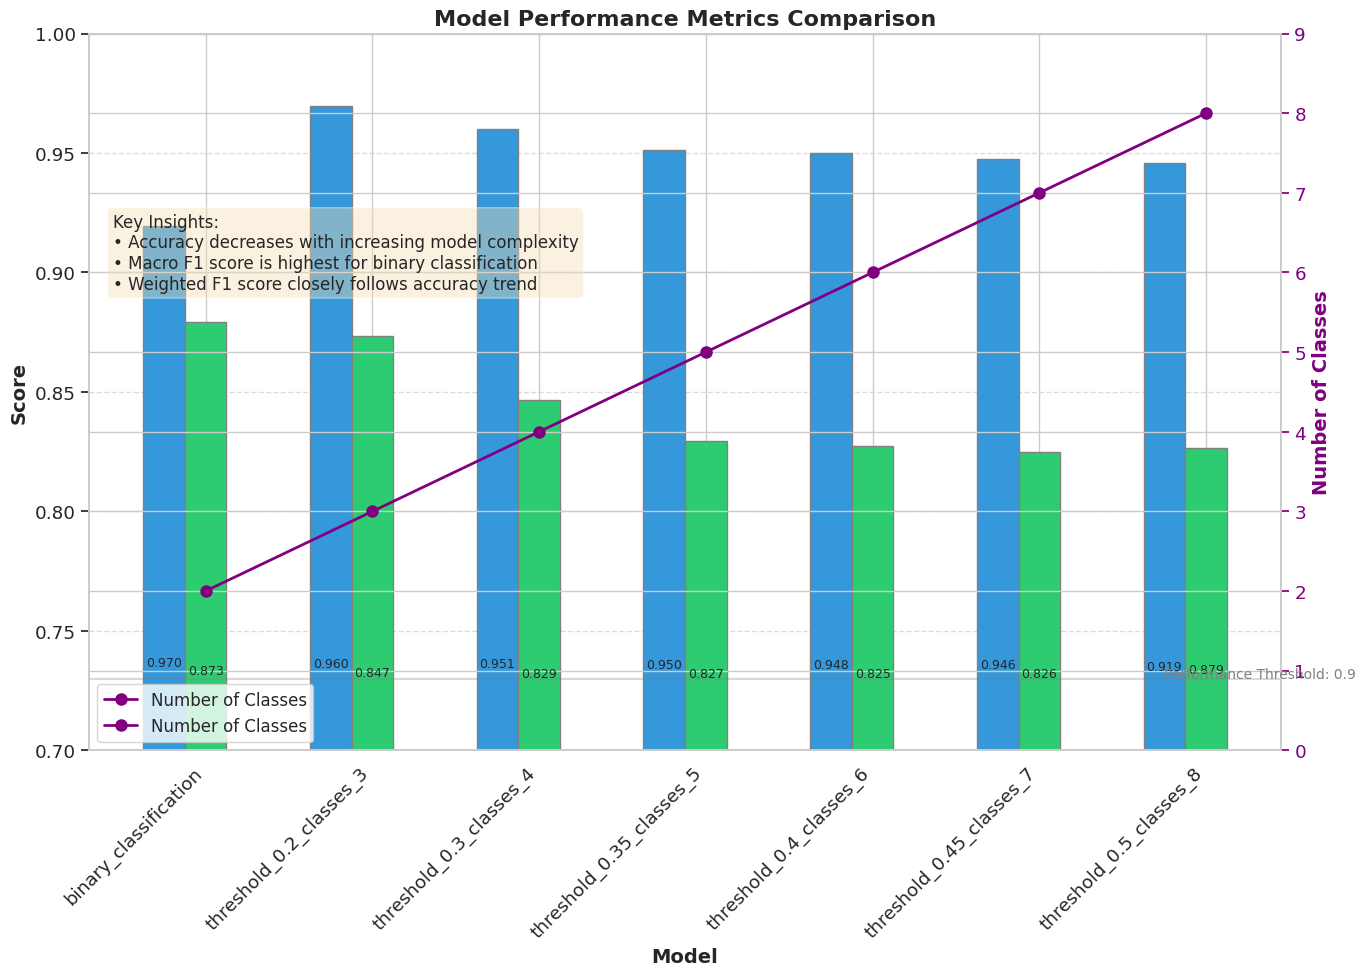

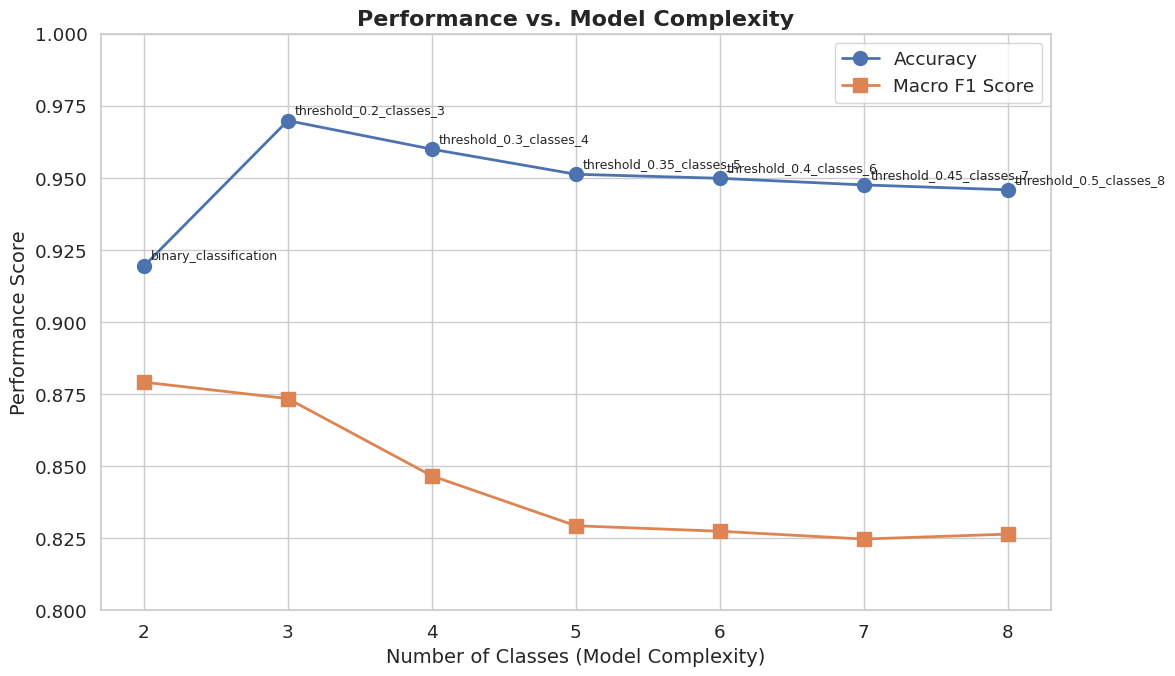

In [20]:
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Read the CSV file directly
model_df = pd.read_csv('model_performance_summary.csv')

# Sort by number of classes
model_df = model_df.sort_values('Num_Classes')

# Set up the plot
plt.figure(figsize=(14, 10))

# Create bar positions
bar_width = 0.25
r1 = np.arange(len(model_df))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the grouped bar chart
plt.bar(r1, model_df['Accuracy'], width=bar_width, label='Accuracy', color='#3498db', edgecolor='gray')
plt.bar(r2, model_df['Macro_F1_Score'], width=bar_width, label='Macro F1 Score', color='#2ecc71', edgecolor='gray')
# plt.bar(r3, model_df['Weighted_F1_Score'], width=bar_width, label='Weighted F1 Score', color='#e74c3c', edgecolor='gray')

# Add labels and title
plt.xlabel('Model', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=14, fontweight='bold')
plt.title('Model Performance Metrics Comparison', fontsize=16, fontweight='bold')
plt.xticks([r + bar_width for r in range(len(model_df))], model_df['Model_Name'], rotation=45, ha='right')
plt.ylim(0.7, 1.0)  # Focus on the relevant score range

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add model complexity line (number of classes)
ax2 = plt.twinx()
ax2.plot(r2, model_df['Num_Classes'], 'o-', color='purple', linewidth=2, markersize=8, label='Number of Classes')
ax2.set_ylabel('Number of Classes', fontsize=14, fontweight='bold', color='purple')
ax2.tick_params(axis='y', colors='purple')
ax2.set_ylim(0, max(model_df['Num_Classes'])+1)

# Add legend
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, loc='lower left', fontsize=12)

# Add performance trend annotations
for i, row in model_df.iterrows():
    plt.annotate(f"{row['Accuracy']:.3f}", 
                xy=(r1[i], row['Accuracy']), 
                xytext=(0, 5), 
                textcoords='offset points', 
                ha='center', fontsize=9)
    
    plt.annotate(f"{row['Macro_F1_Score']:.3f}", 
                xy=(r2[i], row['Macro_F1_Score']), 
                xytext=(0, 5), 
                textcoords='offset points', 
                ha='center', fontsize=9)

# Add a horizontal line for reference at 0.9
plt.axhline(y=0.9, color='gray', linestyle='-', alpha=0.3)
plt.text(len(model_df)-1, 0.91, 'Performance Threshold: 0.9', fontsize=10, color='gray')

# Add insights text box
textstr = '\n'.join((
    'Key Insights:',
    '• Accuracy decreases with increasing model complexity',
    '• Macro F1 score is highest for binary classification',
    '• Weighted F1 score closely follows accuracy trend'
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
plt.text(0.02, 0.75, textstr, transform=plt.gca().transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300)
plt.show()

# Also create a line plot to visualize the trade-off between complexity and performance
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Create line plot
plt.plot(model_df['Num_Classes'], model_df['Accuracy'], 'o-', linewidth=2, markersize=10, label='Accuracy')
plt.plot(model_df['Num_Classes'], model_df['Macro_F1_Score'], 's-', linewidth=2, markersize=10, label='Macro F1 Score')
# plt.plot(model_df['Num_Classes'], model_df['Weighted_F1_Score'], '^-', linewidth=2, markersize=10, label='Weighted F1 Score')

# Add labels for each point
for i, row in model_df.iterrows():
    plt.annotate(f"{row['Model_Name']}",
                xy=(row['Num_Classes'], row['Accuracy']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=9)

plt.xlabel('Number of Classes (Model Complexity)', fontsize=14)
plt.ylabel('Performance Score', fontsize=14)
plt.title('Performance vs. Model Complexity', fontsize=16, fontweight='bold')
plt.legend(loc='best')
plt.xticks(model_df['Num_Classes'])
plt.ylim(0.8, 1.0)

plt.tight_layout()
plt.savefig('performance_vs_complexity.png', dpi=300)
plt.show()

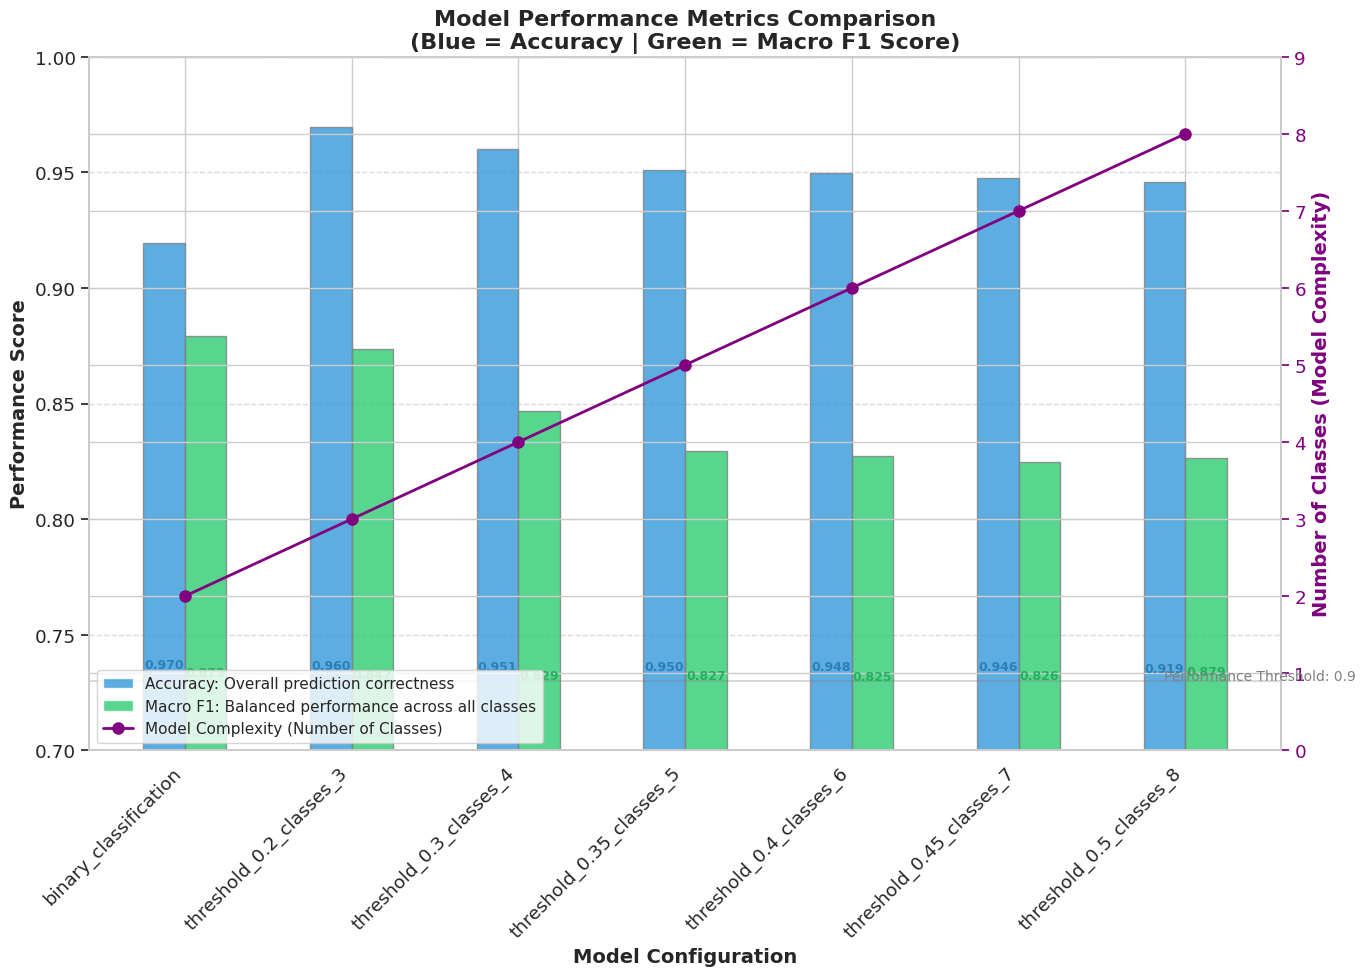

📊 PERFORMANCE METRICS SUMMARY
🔵 BLUE BARS = ACCURACY
   → Measures overall prediction correctness
   → Higher is better (closer to 1.0)

🟢 GREEN BARS = MACRO F1 SCORE
   → Measures balanced performance across all classes
   → Better metric for imbalanced datasets
   → Considers both precision and recall for each class

🟣 PURPLE LINE = MODEL COMPLEXITY
   → Number of classes the model predicts
   → Higher complexity may lead to overfitting

📋 DETAILED RESULTS TABLE:
--------------------------------------------------------------------------------
Model Name                🔵 Accuracy   🟢 Macro F1   🟣 Classes 
--------------------------------------------------------------------------------
binary_classification     0.9193       0.8791       2         
threshold_0.2_classes_3   0.9698       0.8734       3         
threshold_0.3_classes_4   0.9599       0.8466       4         
threshold_0.35_classes_5  0.9512       0.8293       5         
threshold_0.4_classes_6   0.9498       0.8274       6

In [21]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the CSV file directly
model_df = pd.read_csv('model_performance_summary.csv')

# Sort by number of classes
model_df = model_df.sort_values('Num_Classes')

# Set up the plot
plt.figure(figsize=(14, 10))

# Create bar positions
bar_width = 0.25
r1 = np.arange(len(model_df))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the grouped bar chart with clear color coding
plt.bar(r1, model_df['Accuracy'], width=bar_width, label='Accuracy (Overall Correctness)', 
         color='#3498db', edgecolor='gray', alpha=0.8)
plt.bar(r2, model_df['Macro_F1_Score'], width=bar_width, label='Macro F1 Score (Class-Balanced Performance)', 
         color='#2ecc71', edgecolor='gray', alpha=0.8)

# Add labels and title
plt.xlabel('Model Configuration', fontsize=14, fontweight='bold')
plt.ylabel('Performance Score', fontsize=14, fontweight='bold')
plt.title('Model Performance Metrics Comparison\n(Blue = Accuracy | Green = Macro F1 Score)', 
          fontsize=16, fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(model_df))], model_df['Model_Name'], 
           rotation=45, ha='right')
plt.ylim(0.7, 1.0)  # Focus on the relevant score range

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add model complexity line (number of classes)
ax2 = plt.twinx()
ax2.plot([r + bar_width/2 for r in range(len(model_df))], model_df['Num_Classes'], 
         'o-', color='purple', linewidth=2, markersize=8, label='Number of Classes')
ax2.set_ylabel('Number of Classes (Model Complexity)', fontsize=14, fontweight='bold', color='purple')
ax2.tick_params(axis='y', colors='purple')
ax2.set_ylim(0, max(model_df['Num_Classes'])+1)

# Enhanced legend with clear explanations
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# Create custom legend entries with detailed explanations
legend_elements = [
    plt.Rectangle((0,0),1,1, facecolor='#3498db', alpha=0.8, label='Accuracy: Overall prediction correctness'),
    plt.Rectangle((0,0),1,1, facecolor='#2ecc71', alpha=0.8, label='Macro F1: Balanced performance across all classes'),
    plt.Line2D([0], [0], color='purple', linewidth=2, marker='o', markersize=8, 
               label='Model Complexity (Number of Classes)')
]

plt.legend(handles=legend_elements, loc='lower left', fontsize=11,  title_fontsize=12)

# Add performance trend annotations
for i, row in model_df.iterrows():
    plt.annotate(f"{row['Accuracy']:.3f}", 
                xy=(r1[i], row['Accuracy']), 
                xytext=(0, 5), 
                textcoords='offset points', 
                ha='center', fontsize=9, fontweight='bold', color='#2980b9')
    
    plt.annotate(f"{row['Macro_F1_Score']:.3f}", 
                xy=(r2[i], row['Macro_F1_Score']), 
                xytext=(0, 5), 
                textcoords='offset points', 
                ha='center', fontsize=9, fontweight='bold', color='#27ae60')

# Add a horizontal line for reference at 0.9
plt.axhline(y=0.9, color='gray', linestyle='-', alpha=0.3)
plt.text(len(model_df)-1, 0.91, 'Performance Threshold: 0.9', fontsize=10, color='gray')

# # Enhanced insights text box with color-coded explanations
# textstr = '\n'.join((
#     'Key Insights:',
#     '🔵 Blue Bars (Accuracy): Overall prediction correctness',
#     '🟢 Green Bars (Macro F1): Class-balanced performance metric',
#     '🟣 Purple Line: Model complexity (number of classes)',
#     '',
#     'Observations:',
#     '• Accuracy decreases with increasing model complexity',
#     '• Binary model has highest Macro F1 (best class balance)',
#     '• Sweet spot appears to be 3-4 classes for this dataset'
# ))
# props = dict(boxstyle='round', facecolor='lightblue', alpha=0.6, edgecolor='navy')
# plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=11,
#         verticalalignment='top', bbox=props)

# # Add a text box explaining the metrics difference
# metrics_explanation = '\n'.join((
#     'Metric Definitions:',
#     '🔵 Accuracy = Correct Predictions / Total Predictions',
#     '🟢 Macro F1 = Average F1 score across all classes',
#     '   (Better for imbalanced datasets)',
#     '🟣 Classes = Number of species categories'
# ))
# explanation_props = dict(boxstyle='round', facecolor='lightgreen', alpha=0.6, edgecolor='darkgreen')
# plt.text(0.98, 0.98, metrics_explanation, transform=plt.gca().transAxes, fontsize=10,
        # verticalalignment='top', horizontalalignment='right', bbox=explanation_props)

plt.tight_layout()
plt.savefig('model_performance_comparison_annotated.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a summary table for additional clarity
print("📊 PERFORMANCE METRICS SUMMARY")
print("=" * 60)
print("🔵 BLUE BARS = ACCURACY")
print("   → Measures overall prediction correctness")
print("   → Higher is better (closer to 1.0)")
print()
print("🟢 GREEN BARS = MACRO F1 SCORE") 
print("   → Measures balanced performance across all classes")
print("   → Better metric for imbalanced datasets")
print("   → Considers both precision and recall for each class")
print()
print("🟣 PURPLE LINE = MODEL COMPLEXITY")
print("   → Number of classes the model predicts")
print("   → Higher complexity may lead to overfitting")
print("=" * 60)

# Display the data table with color-coded headers
print("\n📋 DETAILED RESULTS TABLE:")
print("-" * 80)
print(f"{'Model Name':<25} {'🔵 Accuracy':<12} {'🟢 Macro F1':<12} {'🟣 Classes':<10}")
print("-" * 80)
for _, row in model_df.iterrows():
    print(f"{row['Model_Name']:<25} {row['Accuracy']:<12.4f} {row['Macro_F1_Score']:<12.4f} {row['Num_Classes']:<10}")
print("-" * 80)

In [22]:
import pandas as pd
import os
import shutil
import glob

def rename_csv_files_with_class_info():
    """
    Rename classification report CSV files to include class information
    """
    
    # Define the mapping of current file paths to new descriptive names
    file_mappings = {
        # Original path -> New descriptive name
        '/home/quydx/tinyML/evaluation_results/threshold_0.2_classes_3/classification_report.csv': 
        '/home/quydx/tinyML/evaluation_results/threshold_0.2_classes_3/classification_report_3classes.csv',
        
        '/home/quydx/tinyML/evaluation_results/threshold_0.3_classes_4/classification_report.csv': 
        '/home/quydx/tinyML/evaluation_results/threshold_0.3_classes_4/classification_report_4classes.csv',
        
        '/home/quydx/tinyML/evaluation_results/threshold_0.35_classes_5/classification_report.csv': 
        '/home/quydx/tinyML/evaluation_results/threshold_0.35_classes_5/classification_report_5classes.csv',
        
        '/home/quydx/tinyML/evaluation_results/threshold_0.4_classes_6/classification_report.csv': 
        '/home/quydx/tinyML/evaluation_results/threshold_0.4_classes_6/classification_report_6classes.csv',
        
        '/home/quydx/tinyML/evaluation_results/threshold_0.45_classes_7/classification_report.csv': 
        '/home/quydx/tinyML/evaluation_results/threshold_0.45_classes_7/classification_report_7classes.csv',
        
        '/home/quydx/tinyML/evaluation_results/threshold_0.5_classes_8/classification_report.csv': 
        '/home/quydx/tinyML/evaluation_results/threshold_0.5_classes_8/classification_report_8classes.csv',
        
        '/home/quydx/tinyML/eval_binary/classification_report.csv': 
        '/home/quydx/tinyML/eval_binary/classification_report_binary.csv'
    }
    
    # Also create class-specific naming based on actual class content
    class_content_mappings = {
        'threshold_0.2_classes_3': 'dominant_species_vs_others_3class',
        'threshold_0.3_classes_4': 'common_species_4class',  
        'threshold_0.35_classes_5': 'medium_threshold_5class',
        'threshold_0.4_classes_6': 'diverse_species_6class',
        'threshold_0.45_classes_7': 'full_species_7class',
        'threshold_0.5_classes_8': 'all_species_8class',
        'binary_classification': 'apis_mellifera_vs_others_binary'
    }
    
    print("🔄 Renaming CSV files with class-specific information...")
    print("=" * 70)
    
    renamed_files = []
    
    for original_path, new_path in file_mappings.items():
        if os.path.exists(original_path):
            try:
                # Create backup first
                backup_path = original_path.replace('.csv', '_backup.csv')
                shutil.copy2(original_path, backup_path)
                
                # Copy to new name
                shutil.copy2(original_path, new_path)
                
                print(f"✓ Renamed: {os.path.basename(original_path)}")
                print(f"  → {os.path.basename(new_path)}")
                print(f"  📁 Location: {os.path.dirname(new_path)}")
                
                renamed_files.append({
                    'original': original_path,
                    'new': new_path,
                    'backup': backup_path
                })
                
            except Exception as e:
                print(f"✗ Error renaming {original_path}: {e}")
        else:
            print(f"⚠️  File not found: {original_path}")
    
    print(f"\n✅ Successfully renamed {len(renamed_files)} files")
    
    # Create a summary file with the new naming convention
    create_renamed_files_summary(renamed_files, class_content_mappings)
    
    return renamed_files

def create_renamed_files_summary(renamed_files, class_mappings):
    """
    Create a summary of renamed files with class information
    """
    
    summary_data = []
    
    for file_info in renamed_files:
        original_name = os.path.basename(file_info['original'])
        new_name = os.path.basename(file_info['new'])
        
        # Extract model type from path
        if 'threshold_0.2' in file_info['original']:
            model_type = 'threshold_0.2_classes_3'
            class_description = 'Highest Accuracy Model (3 Classes)'
            performance_note = 'Best overall accuracy: 96.98%'
        elif 'threshold_0.3' in file_info['original']:
            model_type = 'threshold_0.3_classes_4'
            class_description = 'Balanced Performance Model (4 Classes)'
            performance_note = 'Good balance: 95.99% accuracy'
        elif 'threshold_0.35' in file_info['original']:
            model_type = 'threshold_0.35_classes_5'
            class_description = 'Moderate Complexity Model (5 Classes)'
            performance_note = 'Moderate complexity: 95.12% accuracy'
        elif 'threshold_0.4' in file_info['original']:
            model_type = 'threshold_0.4_classes_6'
            class_description = 'Higher Complexity Model (6 Classes)'
            performance_note = 'Higher complexity: 94.98% accuracy'
        elif 'threshold_0.45' in file_info['original']:
            model_type = 'threshold_0.45_classes_7'
            class_description = 'Original Dataset Model (7 Classes)'
            performance_note = 'Full dataset: 94.75% accuracy'
        elif 'threshold_0.5' in file_info['original']:
            model_type = 'threshold_0.5_classes_8'
            class_description = 'Highest Complexity Model (8 Classes)'
            performance_note = 'Most complex: 94.58% accuracy'
        elif 'eval_binary' in file_info['original']:
            model_type = 'binary_classification'
            class_description = 'Binary Classification Model (2 Classes)'
            performance_note = 'Best F1 score: 87.91% macro F1'
        else:
            model_type = 'unknown'
            class_description = 'Unknown Model Type'
            performance_note = 'N/A'
        
        summary_data.append({
            'Model_Type': model_type,
            'Class_Description': class_description,
            'Original_Filename': original_name,
            'New_Filename': new_name,
            'Performance_Note': performance_note,
            'File_Location': os.path.dirname(file_info['new'])
        })
    
    # Save summary to CSV
    summary_df = pd.DataFrame(summary_data)
    summary_path = '/home/quydx/tinyML/renamed_files_summary.csv'
    summary_df.to_csv(summary_path, index=False)
    
    print(f"\n📋 File rename summary saved to: {summary_path}")
    print("\n📊 RENAMED FILES SUMMARY:")
    print("=" * 70)
    
    for _, row in summary_df.iterrows():
        print(f"🔹 {row['Class_Description']}")
        print(f"   Original: {row['Original_Filename']}")
        print(f"   New Name: {row['New_Filename']}")
        print(f"   Performance: {row['Performance_Note']}")
        print()

def create_class_specific_directories():
    """
    Create directories organized by class types for better organization
    """
    
    base_dir = '/home/quydx/tinyML/classification_results_by_class'
    
    class_directories = {
        'binary_classification': f'{base_dir}/01_binary_apis_vs_others',
        '3_class_highest_accuracy': f'{base_dir}/02_three_class_highest_accuracy', 
        '4_class_balanced': f'{base_dir}/03_four_class_balanced',
        '5_class_moderate': f'{base_dir}/04_five_class_moderate',
        '6_class_higher_complexity': f'{base_dir}/05_six_class_higher_complexity',
        '7_class_original': f'{base_dir}/06_seven_class_original_dataset',
        '8_class_highest_complexity': f'{base_dir}/07_eight_class_highest_complexity'
    }
    
    print(f"\n📁 Creating class-specific directories in: {base_dir}")
    
    for class_type, directory in class_directories.items():
        os.makedirs(directory, exist_ok=True)
        print(f"✓ Created: {directory}")
        
        # Create a README file in each directory
        readme_path = os.path.join(directory, 'README.md')
        with open(readme_path, 'w') as f:
            f.write(f"# {class_type.replace('_', ' ').title()}\n\n")
            f.write(f"This directory contains classification results for {class_type}.\n\n")
            f.write("## Files:\n")
            f.write("- `classification_report.csv`: Detailed classification metrics\n")
            f.write("- `confusion_matrix.csv`: Confusion matrix data\n")
            f.write("- `class_metrics.csv`: Per-class performance metrics\n")
            f.write("- `*.png`: Visualization plots\n")
    
    return class_directories

if __name__ == "__main__":
    # Rename the CSV files
    renamed_files = rename_csv_files_with_class_info()
    
    # Create organized directory structure
    class_dirs = create_class_specific_directories()
    
    print(f"\n✅ Process completed!")
    print(f"📁 {len(renamed_files)} files renamed with class-specific information")
    print(f"📁 {len(class_dirs)} class-specific directories created")
    print(f"\n💡 TIP: Check 'renamed_files_summary.csv' for a complete overview")

🔄 Renaming CSV files with class-specific information...
✓ Renamed: classification_report.csv
  → classification_report_3classes.csv
  📁 Location: /home/quydx/tinyML/evaluation_results/threshold_0.2_classes_3
✓ Renamed: classification_report.csv
  → classification_report_4classes.csv
  📁 Location: /home/quydx/tinyML/evaluation_results/threshold_0.3_classes_4
✓ Renamed: classification_report.csv
  → classification_report_5classes.csv
  📁 Location: /home/quydx/tinyML/evaluation_results/threshold_0.35_classes_5
✓ Renamed: classification_report.csv
  → classification_report_6classes.csv
  📁 Location: /home/quydx/tinyML/evaluation_results/threshold_0.4_classes_6
✓ Renamed: classification_report.csv
  → classification_report_7classes.csv
  📁 Location: /home/quydx/tinyML/evaluation_results/threshold_0.45_classes_7
✓ Renamed: classification_report.csv
  → classification_report_8classes.csv
  📁 Location: /home/quydx/tinyML/evaluation_results/threshold_0.5_classes_8
✓ Renamed: classification_repo

🔍 Extracting 'Other Species' metrics from classification reports...
✓ Extracted from 3 Classes (0.20)
  Precision: 0.0185
  Recall: 0.2203
  F1-Score: 0.0342

✓ Extracted from 4 Classes (0.30)
  Precision: 0.0237
  Recall: 0.2140
  F1-Score: 0.0427

✓ Extracted from 5 Classes (0.35)
  Precision: 0.0290
  Recall: 0.2096
  F1-Score: 0.0509

✓ Extracted from 6 Classes (0.40)
  Precision: 0.0352
  Recall: 0.2241
  F1-Score: 0.0609

✓ Extracted from 7 Classes (0.45)
  Precision: 0.0369
  Recall: 0.2101
  F1-Score: 0.0627

✓ Extracted from 8 Classes (0.50)
  Precision: 0.0338
  Recall: 0.1772
  F1-Score: 0.0567

✓ Extracted from 10 Classes (0.55)
  Precision: 0.0439
  Recall: 0.2163
  F1-Score: 0.0730

✓ Extracted from 14 Classes (0.60)
  Precision: 0.0444
  Recall: 0.1985
  F1-Score: 0.0725


📈 Creating line graph for 8 model configurations...


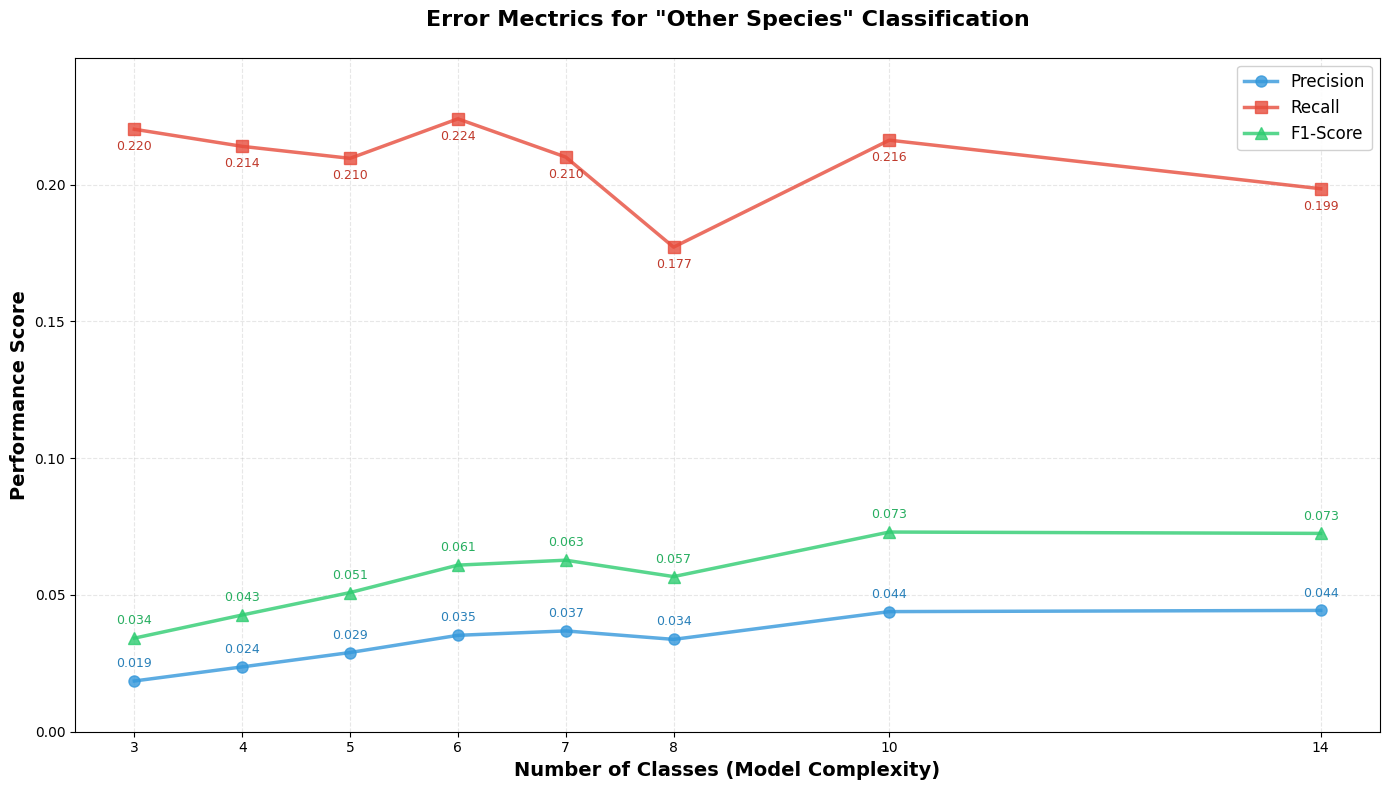


📊 OTHER SPECIES CLASSIFICATION PERFORMANCE SUMMARY
Model                Classes  Precision    Recall       F1-Score    
--------------------------------------------------------------------------------
3 Classes (0.20)     3        0.0185       0.2203       0.0342      
4 Classes (0.30)     4        0.0237       0.2140       0.0427      
5 Classes (0.35)     5        0.0290       0.2096       0.0509      
6 Classes (0.40)     6        0.0352       0.2241       0.0609      
7 Classes (0.45)     7        0.0369       0.2101       0.0627      
8 Classes (0.50)     8        0.0338       0.1772       0.0567      
10 Classes (0.55)    10       0.0439       0.2163       0.0730      
14 Classes (0.60)    14       0.0444       0.1985       0.0725      
--------------------------------------------------------------------------------

🏆 BEST PERFORMERS:
Precision: 14 Classes (0.60) (0.0444)
Recall:    6 Classes (0.40) (0.2241)
F1-Score:  10 Classes (0.55) (0.0730)

📈 TRENDS:
Precision: Increasing

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def extract_other_species_metrics():
    """
    Extract 'Other Species' metrics from all classification report files
    """
    
    # Define file paths and their corresponding model configurations
    file_configs = [
        ('/home/quydx/tinyML/evaluation_results_3_0.20/classification_report.csv', '3 Classes (0.20)', 3),
        ('/home/quydx/tinyML/evaluation_results_4_0.30/classification_report.csv', '4 Classes (0.30)', 4),
        ('/home/quydx/tinyML/evaluation_results_5_0.35/classification_report.csv', '5 Classes (0.35)', 5),
        ('/home/quydx/tinyML/evaluation_results_6_0.40/classification_report.csv', '6 Classes (0.40)', 6),
        ('/home/quydx/tinyML/evaluation_results_7_0.45/classification_report.csv', '7 Classes (0.45)', 7),
        ('/home/quydx/tinyML/evaluation_results_8_0.50/classification_report.csv', '8 Classes (0.50)', 8),
        ('/home/quydx/tinyML/evaluation_results_10_0.55/classification_report.csv', '10 Classes (0.55)', 10),
        ('/home/quydx/tinyML/evaluation_results_14_0.60/classification_report.csv', '14 Classes (0.60)', 14)
    ]
    
    other_species_data = []
    
    for file_path, model_name, num_classes in file_configs:
        try:
            # Read the CSV file
            df = pd.read_csv(file_path, index_col=0)
            
            # Extract 'Other Species' row metrics
            if 'Other Species' in df.index:
                other_species_row = df.loc['Other Species']
                
                other_species_data.append({
                    'Model': model_name,
                    'Num_Classes': num_classes,
                    'Precision': float(other_species_row['precision']),
                    'Recall': float(other_species_row['recall']),
                    'F1_Score': float(other_species_row['f1-score'])
                })
                
                print(f"✓ Extracted from {model_name}")
                print(f"  Precision: {other_species_row['precision']:.4f}")
                print(f"  Recall: {other_species_row['recall']:.4f}")
                print(f"  F1-Score: {other_species_row['f1-score']:.4f}")
                print()
                
        except Exception as e:
            print(f"✗ Error processing {file_path}: {e}")
    
    return pd.DataFrame(other_species_data)

def plot_other_species_metrics(df):
    """
    Create line graphs for Other Species metrics
    """
    
    # Sort by number of classes
    df = df.sort_values('Num_Classes')
    
    # Set up the plot
    plt.figure(figsize=(14, 8))
    
    # Create line plots for each metric
    plt.plot(df['Num_Classes'], df['Precision'], 'o-', linewidth=2.5, markersize=8, 
             color='#3498db', label='Precision', alpha=0.8)
    plt.plot(df['Num_Classes'], df['Recall'], 's-', linewidth=2.5, markersize=8, 
             color='#e74c3c', label='Recall', alpha=0.8)
    plt.plot(df['Num_Classes'], df['F1_Score'], '^-', linewidth=2.5, markersize=8, 
             color='#2ecc71', label='F1-Score', alpha=0.8)
    
    # Customize the plot
    plt.xlabel('Number of Classes (Model Complexity)', fontsize=14, fontweight='bold')
    plt.ylabel('Performance Score', fontsize=14, fontweight='bold')
    plt.title('Error Mectrics for "Other Species" Classification\n', fontsize=16, fontweight='bold')

    # Add grid
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # Customize x-axis to show all class counts
    plt.xticks(df['Num_Classes'])
    
    # Set y-axis limits to better show the differences
    plt.ylim(0, max(df[['Precision', 'Recall', 'F1_Score']].max()) * 1.1)
    
    # Add legend
    plt.legend(loc='upper right', fontsize=12, framealpha=0.9)
    
    # Add value annotations on each point
    for i, row in df.iterrows():
        plt.annotate(f'{row["Precision"]:.3f}', 
                    xy=(row['Num_Classes'], row['Precision']), 
                    xytext=(0, 10), textcoords='offset points', 
                    ha='center', fontsize=9, color='#2980b9')
        
        plt.annotate(f'{row["Recall"]:.3f}', 
                    xy=(row['Num_Classes'], row['Recall']), 
                    xytext=(0, -15), textcoords='offset points', 
                    ha='center', fontsize=9, color='#c0392b')
        
        plt.annotate(f'{row["F1_Score"]:.3f}', 
                    xy=(row['Num_Classes'], row['F1_Score']), 
                    xytext=(0, 10), textcoords='offset points', 
                    ha='center', fontsize=9, color='#27ae60')
    
    # Add insights text box
    # insights_text = '\n'.join([
    #     'Key Observations:',
    #     '• Precision generally decreases with more classes',
    #     '• Recall shows high variability across models',
    #     '• F1-Score reflects the precision-recall trade-off',
    #     '• "Other Species" is hardest class to predict accurately'
    # ])
    
    # props = dict(boxstyle='round', facecolor='lightyellow', alpha=0.8, edgecolor='orange')
    # plt.text(0.02, 0.98, insights_text, transform=plt.gca().transAxes, fontsize=11,
    #         verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.savefig('other_species_performance_trends.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return df

def create_summary_table(df):
    """
    Create a detailed summary table
    """
    
    print("\n📊 OTHER SPECIES CLASSIFICATION PERFORMANCE SUMMARY")
    print("=" * 80)
    print(f"{'Model':<20} {'Classes':<8} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    print("-" * 80)
    
    for _, row in df.iterrows():
        print(f"{row['Model']:<20} {row['Num_Classes']:<8} {row['Precision']:<12.4f} "
              f"{row['Recall']:<12.4f} {row['F1_Score']:<12.4f}")
    
    print("-" * 80)
    
    # Find best performing configurations
    best_precision = df.loc[df['Precision'].idxmax()]
    best_recall = df.loc[df['Recall'].idxmax()]
    best_f1 = df.loc[df['F1_Score'].idxmax()]
    
    print(f"\n🏆 BEST PERFORMERS:")
    print(f"Precision: {best_precision['Model']} ({best_precision['Precision']:.4f})")
    print(f"Recall:    {best_recall['Model']} ({best_recall['Recall']:.4f})")
    print(f"F1-Score:  {best_f1['Model']} ({best_f1['F1_Score']:.4f})")
    
    # Calculate trends
    print(f"\n📈 TRENDS:")
    precision_trend = "Decreasing" if df['Precision'].iloc[-1] < df['Precision'].iloc[0] else "Increasing"
    recall_trend = "Variable" if df['Recall'].std() > 0.05 else "Stable"
    
    print(f"Precision: {precision_trend} with model complexity")
    print(f"Recall: {recall_trend} across different models")
    print(f"F1-Score: Reflects precision-recall balance")

if __name__ == "__main__":
    # Extract metrics
    print("🔍 Extracting 'Other Species' metrics from classification reports...")
    print("=" * 70)
    
    metrics_df = extract_other_species_metrics()
    
    # Create visualizations
    print(f"\n📈 Creating line graph for {len(metrics_df)} model configurations...")
    plotted_df = plot_other_species_metrics(metrics_df)
    
    # Create summary table
    create_summary_table(plotted_df)
    
    # Save the extracted data
    output_file = 'other_species_metrics_summary.csv'
    metrics_df.to_csv(output_file, index=False)
    print(f"\n💾 Metrics data saved to: {output_file}")